#Install Libraries

In [1]:
!pip install pykeops
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.3/222.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pykeops: filename=pykeops-2.1.2-py3-none-any.whl size=114077 sha256=c5adec3729db8a8a859a25abfbe3278e5526407567bb029ba4a789021d3930e4
  Stored in directory: /root/.cache/pip/wheels/93/91/9e/279e56403818cf05d868c2d90a13bde97572bcd11673d6e8ef
  Created wheel for keopscore: filename=keopscore-2.1.2-py3-none-any.whl size=146447 sha256=826656d6bf75868a0f6f081f4ce2d0fc62c7c5a9f597862dad333068ec3666ef
  Stored in directory: /root/.cache/pip/wheels/63/ac/b7/75fb4d24be97d9a930905eddf822cb765ca204b83df7aeaaa9
Successfully built pykeops keopscore
Looking in indexe

#Importing Libraries

In [ ]:
import pickle
import os
import time
from google.cloud import storage
from google.cloud.storage.blob import Blob
from google.colab import auth
import pandas as pd
import numpy as np
import json
import glob
import sklearn
from datetime import datetime
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import torch
import os, json, gc, re, random
from tqdm.notebook import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sentence_transformers import SentenceTransformer


import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None 


Updated property [core/project].


# Download `arxiv-metadata-oai-snapshot.json` @ https://www.kaggle.com/datasets/Cornell-University/arxiv

# Reading Dataset and Selcting Columns

In [ ]:
%%time

# Indicate the location of json file
data_file = 'arxiv-metadata-oai-snapshot.json'

""" Using `yield` to load the JSON file in a loop to prevent Python memory issues if JSON is loaded directly"""

def get_metadata(data_file):
    with open(data_file, 'r') as f:
        for line in f:
            yield line

def subselect_ds(data_file):

    categories = []
    abstracts = []

    metadata = get_metadata(data_file)
    for paper in tqdm(metadata):
        paper_dict = json.loads(paper)
        categories.append(paper_dict.get('categories'))
        abstracts.append(paper_dict.get('abstract'))

    return abstracts , categories



abstracts , categories = subselect_ds(data_file)

print("Number of abstracts and categories instances is {}".format(len(abstracts)))

0it [00:00, ?it/s]

Number of abstracts and categories instances is 2250223
CPU times: user 28.9 s, sys: 2.08 s, total: 31 s
Wall time: 30.8 s


#Little Practice to Remove LaTeX

In [ ]:
# Read this: https://stackoverflow.com/questions/54663900/how-to-use-regular-expression-to-remove-all-math-expression-in-latex-file

text = "This is some text with a $\\LaTeX$ formula and a display-style formula: $$\\sum_{n=1}^\\infty \\frac{1}{n^2} = \\frac{\\pi^2}{6}$$."
clean_text = re.sub(r"(\$+)(?:(?!\1)[\s\S])*\1", "", text)
print(clean_text)

This is some text with a  formula and a display-style formula: .


#Cleaning-up and Making Extra Columns

In [ ]:
%%time

papers = pd.DataFrame({
    'abstract': abstracts,
    'categories': categories
})



papers['abstract'] = papers['abstract'].apply(lambda x: x.replace("\n","")) # Remove newline
papers['abstract'] = papers['abstract'].apply(lambda x: re.sub(r"(\$+)(?:(?!\1)[\s\S])*\1", "", x))  # Remove latex formulas
papers['categories'] = papers['categories'].apply(lambda x: x.strip().split()) 
papers['cats_num'] = papers['categories'].apply(len)
papers['abstract_len'] = papers['abstract'].apply(len)


papers

CPU times: user 39.9 s, sys: 1.59 s, total: 41.5 s
Wall time: 41.4 s


,abstract,categories,cats_num,abstract_len
0,A fully differential calculation in perturba...,[hep-ph],1,969
1,"We describe a new algorithm, the -pebble gam...","[math.CO, cs.CG]",2,757
2,The evolution of Earth-Moon system is descri...,[physics.gen-ph],1,868
3,We show that a determinant of Stirling cycle...,[math.CO],1,244
4,In this paper we show how to compute the no...,"[math.CA, math.FA]",2,180
...,...,...,...,...
2250218,We report on measurements of the angular dep...,"[supr-con, cond-mat.supr-con]",2,450
2250219,The non-linear microwave surface impedance o...,"[supr-con, cond-mat.supr-con]",2,638
2250220,The vortex contribution to the dc field (H) ...,"[supr-con, cond-mat.supr-con]",2,1082
2250221,We show that the density of states in an ani...,"[supr-con, cond-mat.supr-con]",2,561


#Hyperparameters for Subselecting the Dataset

In [ ]:
print("Minimum paper length is {}".format(papers["abstract_len"].min()))
print("Maximum paper length is {}".format(papers["abstract_len"].max()))
print("Minimum category length is {}".format(papers["cats_num"].min()))
print("Maximum category length is {}".format(papers["cats_num"].max()))


MIN_PAPER_LEN = 300     # Min number of papers length
MAX_PAPER_LEN = 2200    # Max number of papers length
MAX_CAT_LEN = 4         # Max number of categoreis that ranges from 1 till 13
MIN_CAT_FREQ = 100000   # Min frequency number of categories
FEATURES_NUM = 459      # The number of features for word embeddings
AVG_CHAR_WORD = 5.5     # The average number of chars in English words

Minimum paper length is 5
Maximum paper length is 6011
Minimum category length is 1
Maximum category length is 13


# Subselecting Dataset Phase I

In [ ]:
%%time

papers = papers[papers["abstract_len"] > MIN_PAPER_LEN].reset_index(drop=True)
papers = papers[papers["abstract_len"] < MAX_PAPER_LEN].reset_index(drop=True)
papers = papers[papers["cats_num"] < MAX_CAT_LEN].reset_index(drop=True)

papers

CPU times: user 1.04 s, sys: 121 ms, total: 1.16 s
Wall time: 1.14 s


,abstract,categories,cats_num,abstract_len
0,A fully differential calculation in perturba...,[hep-ph],1,969
1,"We describe a new algorithm, the -pebble gam...","[math.CO, cs.CG]",2,757
2,The evolution of Earth-Moon system is descri...,[physics.gen-ph],1,868
3,We study the two-particle wave function of p...,[cond-mat.mes-hall],1,886
4,A rather non-standard quantum representation...,[gr-qc],1,1022
...,...,...,...,...
2010533,We report on measurements of the angular dep...,"[supr-con, cond-mat.supr-con]",2,450
2010534,The non-linear microwave surface impedance o...,"[supr-con, cond-mat.supr-con]",2,638
2010535,The vortex contribution to the dc field (H) ...,"[supr-con, cond-mat.supr-con]",2,1082
2010536,We show that the density of states in an ani...,"[supr-con, cond-mat.supr-con]",2,561


# Creating Category Frequency Index

In [ ]:
# Collecting labels
labels = []
for item in papers['categories']:
    labels.extend(item)

# Counting them
from collections import Counter
labels_freqs = Counter(labels)

# Creating dataframe and sort it
df = pd.DataFrame(labels_freqs.items(), columns=['category','frequency'])
df = df.sort_values(by = "frequency", ascending=False)

df.tail(100)

,category,frequency
107,cs.IR,11748
18,math.RA,11709
58,physics.bio-ph,11421
28,math.QA,11346
122,cs.HC,11230
...,...,...
165,atom-ph,83
156,acc-phys,40
167,plasm-ph,33
162,ao-sci,15


# Subselecting Dataset Phase II

In [ ]:
%%time

def convert_cat_to_freq(cat_lists):
    return [labels_freqs[cat] for cat in cat_lists]


papers['min_freq'] = papers['categories'].apply(lambda x: sum(convert_cat_to_freq(x)))
papers = papers[papers["min_freq"] > MIN_CAT_FREQ].reset_index(drop=True)

papers

CPU times: user 1.64 s, sys: 25.4 ms, total: 1.67 s
Wall time: 1.66 s


,abstract,categories,cats_num,abstract_len,min_freq
0,A fully differential calculation in perturba...,[hep-ph],1,969,144858
1,The pure spinor formulation of the ten-dimen...,[hep-th],1,379,124203
2,"In this work, we evaluate the lifetimes of t...",[hep-ph],1,746,144858
3,We give a prescription for how to compute th...,[hep-th],1,410,124203
4,We present recent advances in understanding ...,"[cond-mat.str-el, cond-mat.stat-mech]",2,646,120828
...,...,...,...,...,...
621741,We study integrals of motion for Hirota bili...,"[solv-int, hep-th, nlin.SI]",3,460,130859
621742,"The local Sugawara constructions of the ""sma...","[solv-int, hep-th, nlin.SI]",3,829,130859
621743,The analogy between the Cooper pair in high ...,"[supr-con, cond-mat.supr-con, hep-th]",3,811,163160
621744,We present simulations of flux-gradient-driv...,"[supr-con, cond-mat.mtrl-sci, cond-mat.supr-con]",3,620,119114


# Creating Sentence Embedder

In [ ]:
words_appox = papers['abstract_len']/AVG_CHAR_WORD

print("The number of instances bigger than 512 seq is {}".format(papers[words_appox > 512].shape[0]))
print("The percentage of instances bigger than 512 seq is {0:.5f}".format(papers[words_appox > 512].shape[0]/papers.shape[0]))


"""
    We get the justifcation of model selection based on  the above analysis: max_seq_length with 512 is good enough 
    We can also use the classic huggingfac BERT model for doing so as follow:

        Probing BERT for Sentence Embedding:
            model(**tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)).last_hidden_state.mean(axis=1).reshape(768)

    We prefer the Sentence-BERT over BERT as it hase better quality and 6 times faster.

    See https://www.sbert.net/docs/pretrained_models.html for more references

"""

model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
# model = SentenceTransformer('average_word_embeddings_glove.6B.300d')

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

The number of instances bigger than 512 seq is 0
The percentage of instances bigger than 512 seq is 0.00000


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

# Get the Sentence Embeddings for the Whole Dataset 

In [ ]:
%%time

sentence_embeddings = model.encode(papers["abstract"])

print("The shape of embedding tensor is {}".format(sentence_embeddings.shape))

# papers['features'] = sentence_embeddings.tolist()
# papers.to_csv("dataset_with_features.csv", index=False)
# papers

The shape of embedding tensor is (621746, 384)
CPU times: user 20min 27s, sys: 29.6 s, total: 20min 57s
Wall time: 10min 11s


# GPU-based K-Means Algorithms Using PyKeops Lib

In [ ]:
# See https://www.kernel-operations.io/keops/_auto_tutorials/kmeans/plot_kmeans_torch.html for more details

from pykeops.torch import LazyTensor

use_cuda = torch.cuda.is_available()
dtype = torch.float32 if use_cuda else torch.float64
device_id = "cuda:0" if use_cuda else "cpu"


def keops_KMeans(x, K=10, Niter=10, verbose=True):
    """Implements Lloyd's algorithm for the Euclidean metric."""

    start = time.time()
    N, D = x.shape  # Number of samples, dimension of the ambient space

    c = x[:K, :].clone()  # Simplistic initialization for the centroids


    x_i = LazyTensor(x.view(N, 1, D))  # (N, 1, D) samples
    c_j = LazyTensor(c.view(1, K, D))  # (1, K, D) centroids

    # K-means loop:
    # - x  is the (N, D) point cloud,
    # - cl is the (N,) vector of class labels
    # - c  is the (K, D) cloud of cluster centroids
    for i in range(Niter):

        # E step: assign points to the closest cluster -------------------------
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (N, K) symbolic squared distances
        cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

        # M step: update the centroids to the normalized cluster average: ------
        # Compute the sum of points per cluster:
        c.zero_()
        c.scatter_add_(0, cl[:, None].repeat(1, D), x)

        # Divide by the number of points per cluster:
        Ncl = torch.bincount(cl, minlength=K).type_as(c).view(K, 1)
        c /= Ncl  # in-place division to compute the average

    if verbose:  # Fancy display -----------------------------------------------
        if use_cuda:
            torch.cuda.synchronize()
        end = time.time()
        print(
            f"K-means for the Euclidean metric with {N:,} points in dimension {D:,}, K = {K:,}:"
        )
        print(
            "Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n".format(
                Niter, end - start, Niter, (end - start) / Niter
            )
        )


    return cl, c



def keops_KMeans_cosine(x, K=10, Niter=10, verbose=True):
    """Implements Lloyd's algorithm for the Cosine similarity metric."""

    start = time.time()
    N, D = x.shape  # Number of samples, dimension of the ambient space

    c = x[:K, :].clone()  # Simplistic initialization for the centroids
    # Normalize the centroids for the cosine similarity:
    c = torch.nn.functional.normalize(c, dim=1, p=2)

    x_i = LazyTensor(x.view(N, 1, D))  # (N, 1, D) samples
    c_j = LazyTensor(c.view(1, K, D))  # (1, K, D) centroids

    # K-means loop:
    # - x  is the (N, D) point cloud,
    # - cl is the (N,) vector of class labels
    # - c  is the (K, D) cloud of cluster centroids
    for i in range(Niter):

        # E step: assign points to the closest cluster -------------------------
        S_ij = x_i | c_j  # (N, K) symbolic Gram matrix of dot products
        cl = S_ij.argmax(dim=1).long().view(-1)  # Points -> Nearest cluster

        # M step: update the centroids to the normalized cluster average: ------
        # Compute the sum of points per cluster:
        c.zero_()
        c.scatter_add_(0, cl[:, None].repeat(1, D), x)

        # Normalize the centroids, in place:
        c[:] = torch.nn.functional.normalize(c, dim=1, p=2)

    if verbose:  # Fancy display -----------------------------------------------
        if use_cuda:
            torch.cuda.synchronize()
        end = time.time()
        print(
            f"K-means for the cosine similarity with {N:,} points in dimension {D:,}, K = {K:,}:"
        )
        print(
            "Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n".format(
                Niter, end - start, Niter, (end - start) / Niter
            )
        )

    return cl, c

# Reduce Dimension from to 2-D for Visualization

In [ ]:
%%time

from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=2)
features_2d = pca.fit_transform(sentence_embeddings)
features_2d.shape

CPU times: user 22 s, sys: 21.5 s, total: 43.4 s
Wall time: 4.37 s


(621746, 2)

#Plotting K-Means Output for 20 Cluster (A Sample Run)


Without claiming K = 20 as an optimal number of cluster we run the model to see how the documents look like in the semantic space.

K-means for the Euclidean metric with 621,746 points in dimension 2, K = 20:
Timing for 10 iterations: 0.11657s = 10 x 0.01166s



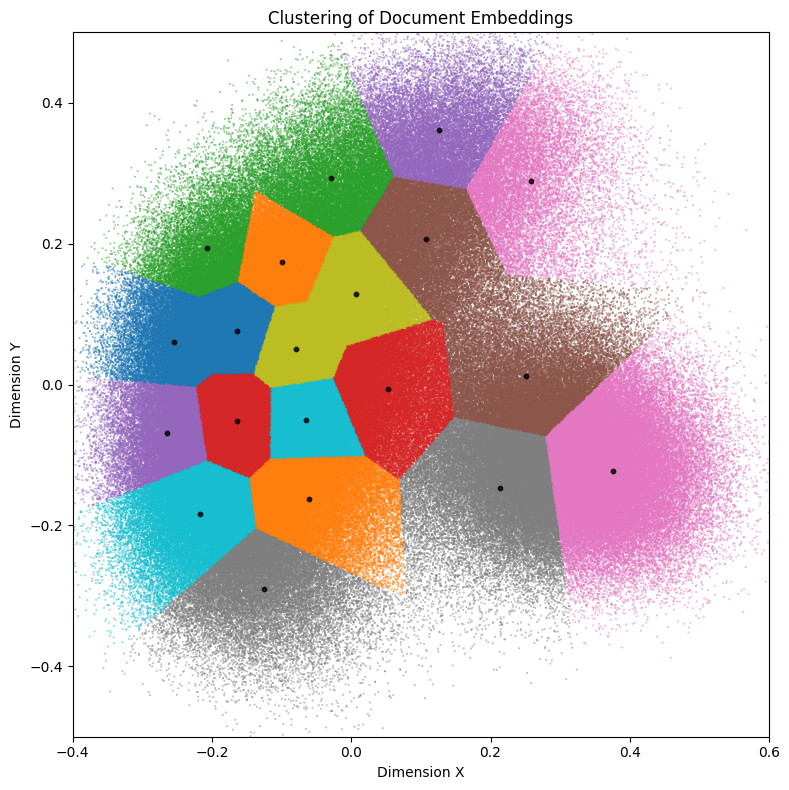

In [ ]:
x = torch.tensor(features_2d)
cl, c = keops_KMeans(x, 20)

plt.figure(figsize=(8, 8))
plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=cl.cpu(), s=0.1, alpha=0.8, cmap="tab10")
plt.scatter(c[:, 0].cpu(), c[:, 1].cpu(), c="black", s=10, alpha=0.8)
plt.title('Clustering of Document Embeddings')
plt.xlabel("Dimension X")
plt.ylabel("Dimension Y")
plt.axis([-0.4, 0.6, -0.5, 0.5])
plt.tight_layout()
plt.show()

#Plotting Original Labels in Semantic Space


In order to compare how semantically the sentences embeddings are we just plot the centroids of each document. This give us an impression why clustering might be needed before applying a proper classification.

In [ ]:
class_label = papers["categories"].apply(lambda x: x[0])

class_dict = {}
for item in set(class_label):
    class_dict[item] = len(class_dict)

class_index = [class_dict[item] for item in class_label]

print("The number of instances per class")
class_label.value_counts()

The number of instances per class


hep-ph      111441
quant-ph     89423
hep-th       84984
cs.LG        56659
gr-qc        24620
             ...  
patt-sol         2
cmp-lg           1
q-bio.CB         1
cs.GL            1
plasm-ph         1
Name: categories, Length: 166, dtype: int64

Finding the centroids of first labels in the list of classes. Of course they are more labels, but, this assumption is enough as we are interested to some samples of original labels.

In [ ]:
centroids = torch.zeros((len(class_dict.keys()),2), dtype=torch.float16)

for idx, cls_lbl in enumerate(class_dict.keys()):
    acc = torch.torch.zeros(2, dtype=torch.float16)
    counter = 0
    for vector_id, class_ in enumerate(class_label):
        if class_ == cls_lbl:
            counter += 1
            acc += x[vector_id]
    centroids[idx] = acc/counter

And finally we can observe that the labels are so dense that makes a hard time for classifiers to work on that. This shows the importance of clustering algorithm, specially if one is interested in search for MORE-LIKE-THIS documents.

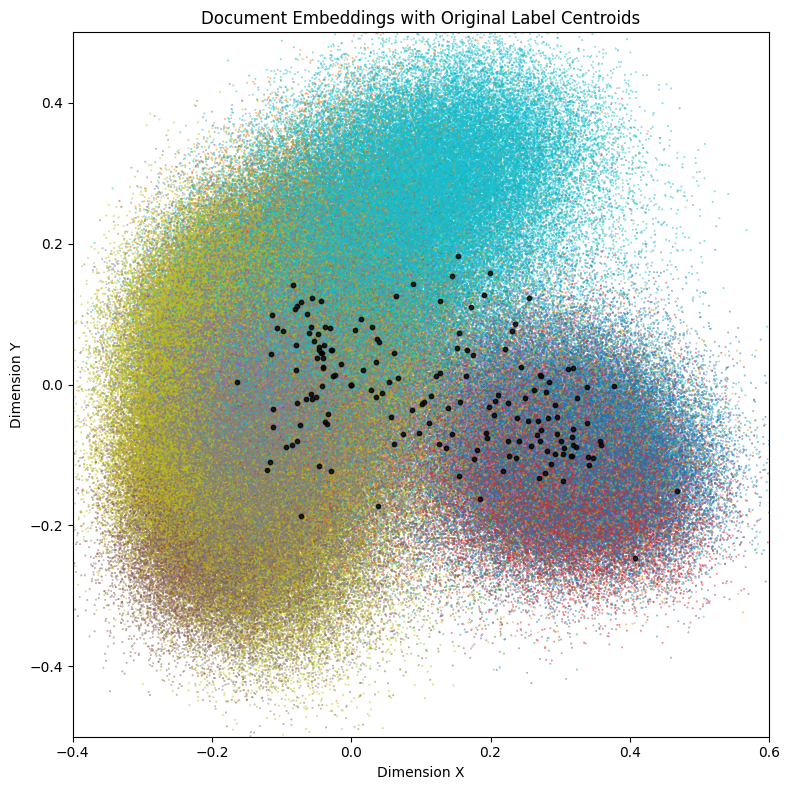

In [ ]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=class_index, s=0.1, alpha=0.8, cmap="tab10")
plt.scatter(centroids[:, 0].cpu(), centroids[:, 1].cpu(), c="black", s=10, alpha=0.8)
plt.title('Document Embeddings with Original Label Centroids')
plt.xlabel("Dimension X")
plt.ylabel("Dimension Y")
plt.axis([-0.4, 0.6, -0.5, 0.5])
plt.tight_layout()
plt.show()

#Plotting Cosine Similarity

Clusters behave as slices around the origin. The centroids shown in black dots show how bad the original labels can be compared with respect to the clustering algorithm output.

K-means for the cosine similarity with 621,746 points in dimension 2, K = 20:
Timing for 10 iterations: 0.21831s = 10 x 0.02183s



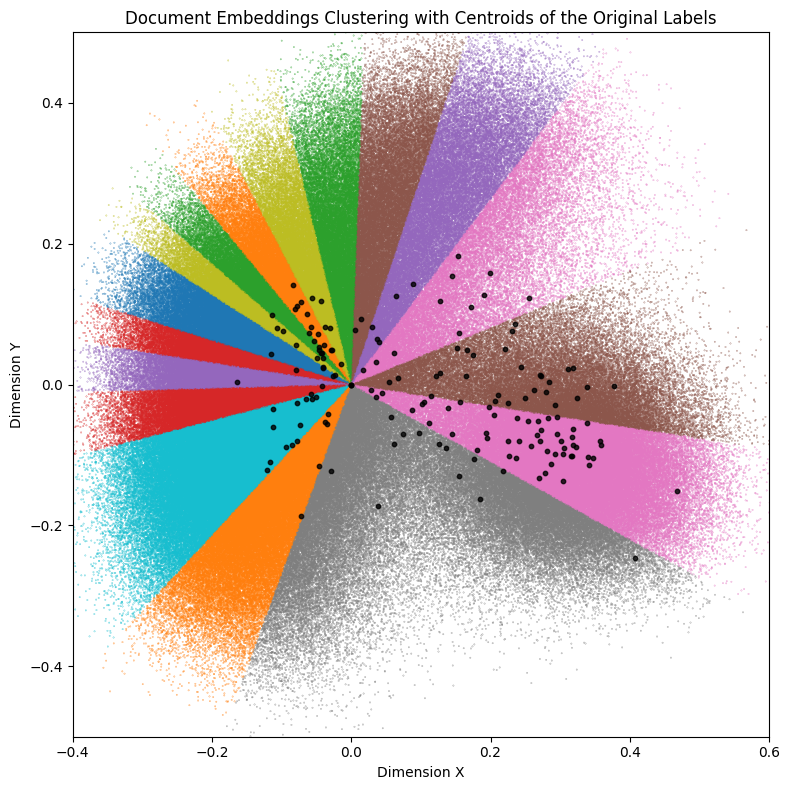

In [ ]:
cl_cosine, c_cosine = keops_KMeans_cosine(x, 20)


plt.figure(figsize=(8, 8))
plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=cl_cosine.cpu(), s=30000 / len(x), cmap="tab10")
plt.scatter(centroids[:, 0].cpu(), centroids[:, 1].cpu(), c="black", s=10, alpha=0.8)
plt.title('Document Embeddings Clustering with Centroids of the Original Labels')
plt.xlabel("Dimension X")
plt.ylabel("Dimension Y")
plt.axis([-0.4, 0.6, -0.5, 0.5])
plt.tight_layout()
plt.show()

#Finding Optimal Number of Clusters

To save some computational resources, we start with coarse-grained SSE/#Clusters parameters (K_start = 2, K_end = 50, step = 5) to find the elbow point. The choice of K=20 as the optimal point seems to be OK and it should vary very little with fine-graned possible options.

  0%|          | 0/10 [00:00<?, ?it/s]

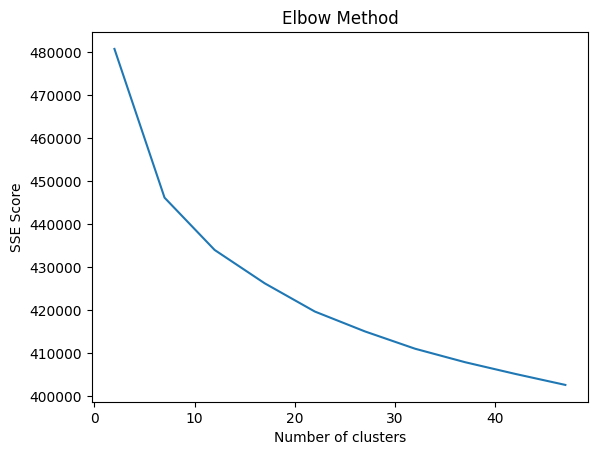

CPU times: user 5h 21min 33s, sys: 3h 15min 34s, total: 8h 37min 8s
Wall time: 45min 33s


In [ ]:
%%time

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

s = []
x_axis = []

for k in tqdm(range(2, 50, 5)):

    kmeans = KMeans(n_clusters=k)
    kmeans.fit(sentence_embeddings)
    sse = kmeans.inertia_
    s.append(sse)
    x_axis.append(k)
    

# Plot the SSE scores against the number of clusters k
plt.plot(x_axis, s)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE Score')
plt.show()

# Creating New Labels from Optimal Clusters

Running the Clustering Algorithm with optimal number of clusters and saving the clusters labels for further text classification algorithm 

In [ ]:
cl, c = keops_KMeans(torch.tensor(sentence_embeddings), 20)

papers['cluster_label'] = cl.tolist()
papers

K-means for the Euclidean metric with 621,746 points in dimension 384, K = 20:
Timing for 10 iterations: 7.51890s = 10 x 0.75189s



,abstract,categories,cats_num,abstract_len,min_freq,cluster_label
0,A fully differential calculation in perturba...,[hep-ph],1,969,144858,2
1,The pure spinor formulation of the ten-dimen...,[hep-th],1,379,124203,1
2,"In this work, we evaluate the lifetimes of t...",[hep-ph],1,746,144858,2
3,We give a prescription for how to compute th...,[hep-th],1,410,124203,3
4,We present recent advances in understanding ...,"[cond-mat.str-el, cond-mat.stat-mech]",2,646,120828,4
...,...,...,...,...,...,...
621741,We study integrals of motion for Hirota bili...,"[solv-int, hep-th, nlin.SI]",3,460,130859,8
621742,"The local Sugawara constructions of the ""sma...","[solv-int, hep-th, nlin.SI]",3,829,130859,1
621743,The analogy between the Cooper pair in high ...,"[supr-con, cond-mat.supr-con, hep-th]",3,811,163160,2
621744,We present simulations of flux-gradient-driv...,"[supr-con, cond-mat.mtrl-sci, cond-mat.supr-con]",3,620,119114,19


To be used for the next stage `Text Classification`



In [ ]:
papers.to_csv("dataset_with_clusters.csv", index=False)